In [1]:
from IPython.display import display

In [2]:
import pandas as pd
import numpy as np

In [3]:
train_frame = pd.read_csv('data/train.csv')
train_frame.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [4]:
test_frame = pd.read_csv('data/test.csv')
test_frame.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [5]:
train_frame.shape, test_frame.shape

((7613, 5), (3263, 4))

In [6]:
train_frame.describe()

,id,target
count,7613.000000,7613.00000
mean,5441.934848,0.42966
std,3137.116090,0.49506
min,1.000000,0.00000
25%,2734.000000,0.00000
50%,5408.000000,0.00000
75%,8146.000000,1.00000
max,10873.000000,1.00000


In [7]:
train_frame.isnull().sum()

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

In [8]:
from autocorrect import Speller

In [9]:
def clean_test(p):
    
    list_char = list("""!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n""")
    list_start = "http 1 2 3 4 5 6 7 8 9".split(' ')

    for char in list_char:
        p = p.replace(char, '')
        
    p_list = p.split()
    
    for start in list_start:
        for word in p_list:
            if start in word:
                p_list.remove(word)
                
    """spell = Speller(lang='en')
    for i in range(len(p_list)):
        p_list[i] = spell(p_list[i])"""
    
    p = ' '.join(p_list)
    
    return p

In [10]:
train_frame['clean_text'] = [clean_test(phrase) for phrase in train_frame.text.to_numpy()]
test_frame['clean_text'] = [clean_test(phrase) for phrase in test_frame.text.to_numpy()]

In [11]:
from keras.preprocessing.text import Tokenizer

In [12]:
data_token = Tokenizer()
data_token.fit_on_texts(np.concatenate((train_frame.clean_text.to_numpy(), test_frame.clean_text.to_numpy())))

vocab = data_token.word_index

In [13]:
train_sequence = data_token.texts_to_sequences(train_frame.clean_text.to_numpy())

In [14]:
from keras.utils import pad_sequences

In [25]:
train_data = pad_sequences(train_sequence)
train_data.shape

(7613, 31)

In [24]:
from sklearn.model_selection import train_test_split

In [27]:
x_train, x_valid, y_train, y_valid = train_test_split(train_data, train_frame.target.to_numpy(), test_size=0.2, random_state=42)
x_train.shape, x_valid.shape, y_train.shape, y_valid.shape

((6090, 31), (1523, 31), (6090,), (1523,))

In [32]:
from keras.models import Sequential
from keras.layers import Embedding, GlobalMaxPool1D, Dense, Input
from keras.activations import relu, sigmoid

In [52]:
model = Sequential()

model.add(Input(shape=(train_data.shape[1],), name='input'))

model.add(Embedding(input_dim = len(vocab), output_dim=64, name='embedding'))
model.add(GlobalMaxPool1D())
model.add(Dense(64, activation=relu, name='dense0'))

model.add(Dense(1, activation=sigmoid, name='output'))

model.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 31, 64)            1423744   
                                                                 
 global_max_pooling1d_3 (Glo  (None, 64)               0         
 balMaxPooling1D)                                                
                                                                 
 dense0 (Dense)              (None, 64)                4160      
                                                                 
 output (Dense)              (None, 1)                 65        
                                                                 
Total params: 1,427,969
Trainable params: 1,427,969
Non-trainable params: 0
_________________________________________________________________


In [46]:
from keras.utils import plot_model

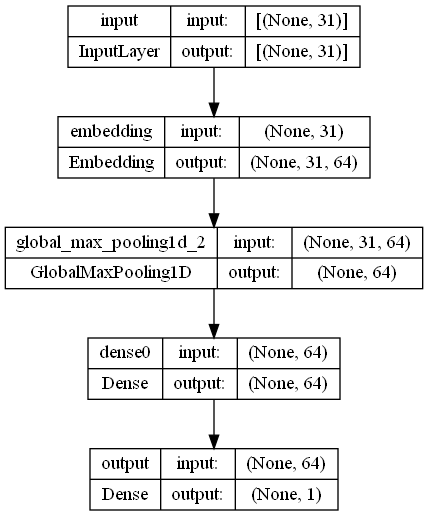

In [48]:
plot_model(model, show_shapes=True, show_layer_names=True)

In [53]:
from keras.optimizers import Adam

In [54]:
opt = Adam(
    learning_rate=0.001,
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-07,
    amsgrad=False,
    name='Adam'
)

In [55]:
from keras.callbacks import EarlyStopping

In [56]:
callback = EarlyStopping(
    monitor="accuracy",
    min_delta=0.01,
    patience=10,
    verbose=1,
    mode="max",
    restore_best_weights=True
)

In [57]:
from keras.losses import BinaryCrossentropy

In [60]:
model.compile(optimizer=opt, loss=BinaryCrossentropy(), metrics=['accuracy'])
model.fit(x_train, y_train, batch_size=100, epochs=100, callbacks=[], validation_data=(x_valid, y_valid), shuffle=True)

Epoch 1/100
61/61 [==============================] - 1s 7ms/step - loss: 0.0192 - accuracy: 0.9885 - val_loss: 1.1412 - val_accuracy: 0.7459
Epoch 2/100
61/61 [==============================] - 0s 6ms/step - loss: 0.0192 - accuracy: 0.9885 - val_loss: 1.1541 - val_accuracy: 0.7492
Epoch 3/100
61/61 [==============================] - 0s 6ms/step - loss: 0.0191 - accuracy: 0.9887 - val_loss: 1.1705 - val_accuracy: 0.7538
Epoch 4/100
61/61 [==============================] - 0s 6ms/step - loss: 0.0191 - accuracy: 0.9885 - val_loss: 1.1763 - val_accuracy: 0.7472
Epoch 5/100
61/61 [==============================] - 0s 6ms/step - loss: 0.0191 - accuracy: 0.9887 - val_loss: 1.1896 - val_accuracy: 0.7498
Epoch 6/100
61/61 [==============================] - 0s 6ms/step - loss: 0.0191 - accuracy: 0.9890 - val_loss: 1.1944 - val_accuracy: 0.7459
Epoch 7/100
61/61 [==============================] - 0s 6ms/step - loss: 0.0192 - accuracy: 0.9882 - val_loss: 1.2076 - val_accuracy: 0.7472
Epoch 8/100
6

KeyboardInterrupt: 